In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skbio.stats.composition import clr, multiplicative_replacement
from scipy.stats import linregress
from biom import load_table
from matplotlib.gridspec import GridSpec
import seaborn as sns
from skbio import TreeNode, DistanceMatrix
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import euclidean
import scipy
from skbio.stats.distance import permanova
from gneiss.util import match, match_tips
from gneiss.sort import niche_sort, mean_niche_estimator

from src.embad import embad
#from matplotlib.ticker import MultipleLocator
%matplotlib inline

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def convert_biom_to_pandas(table):
    """ Unpacks biom table into two pandas dataframes.
    
    The first dataframe will contain the count information for 
    features and samples. The second datafram will contain taxonomy 
    information for all of the OTUs.
    
    Parameters
    ----------
    table : biom.Table
    
    Returns
    -------
    pd.DataFrame
        Contingency table of counts where samples correspond 
        to rows and columns correspond to features (i.e. OTUs)
    pd.DataFrame
        A mapping of OTU names to taxonomic ids
    """

    feature_table = pd.DataFrame(np.array(table.matrix_data.todense()).T,
                                index=table.ids(axis='sample'),
                                columns=table.ids(axis='observation'))
    feature_ids = table.ids(axis='observation')
    mapping = {i: table.metadata(id=i, axis='observation')['taxonomy'] for i in feature_ids}
    # modify below as necessary.  
    # There are typically 7 levels of taxonomy.
    taxonomy = pd.DataFrame(mapping, 
                            index=['kingdom', 'phylum', 'class', 
                                   'order', 'family', 'genus', 'species']).T
    return feature_table, taxonomy


In [3]:
mapping = pd.read_table('../data/post_mortem_mice/10141_prep_1265_qiime_20151201-205734.txt', index_col=0)
table = load_table('../data/post_mortem_mice/485_otu_table.biom')
tree = TreeNode.read('../data/97_otus.tree') 

In [4]:
mapping = mapping.loc[mapping['sample_type'].values=='skin', :]
mapping = mapping.loc[mapping['body_site'].values=='UBERON:skin of head', :]

read_filter = lambda val, id_, md: sum(val) > 100
meta_filter = lambda val, id_, md: id_ in mapping.index
family_filter = lambda id_, x: x['taxonomy'][5]
table.filter(read_filter, axis='sample')
table.filter(meta_filter, axis='sample')
table.filter(read_filter, axis='observation')
mapping = mapping.loc[table.ids(axis='sample'), :]

In [5]:
otu_table, taxonomy = convert_biom_to_pandas(table)
otu_table, otu_tree = match_tips(otu_table, tree)
otu_table, mapping = match(otu_table, mapping)

In [6]:
otu_table = niche_sort(otu_table, mapping.harvest_time_days)

In [7]:
f = lambda x: mean_niche_estimator(x, mapping.harvest_time_days)
mean_day = otu_table.apply(f)
df = pd.merge(taxonomy, pd.DataFrame({'mean_day':mean_day}), left_index=True, right_index=True)
df.to_csv('../results/post_mortem_mice_sorted_days_table.txt', sep='\t')

In [8]:
norm_table = otu_table.apply(lambda x : x / sum(x), axis=1)
big_table = (norm_table * 100000).astype(np.int)
otu_tree = tree.shear(big_table.columns)
dm = beta_diversity('unweighted_unifrac', 
                    big_table.values, 
                    big_table.index, 
                    tree=otu_tree, 
                    otu_ids=big_table.columns)
pc = pcoa(dm)
samples = pc.samples

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.010837512100016766 and the largest is 5.826499275342436.
  RuntimeWarning


In [9]:
b = np.argmax(mapping.harvest_time_days)
fig = plt.figure(figsize=(14, 10))
f = lambda x: euclidean(x.values, samples.loc[b].values)
distances = samples.apply(f, axis=1)

a, b, _, _, _ = scipy.stats.linregress(np.arange(len(samples.index))[::-1], 
                                       np.exp(distances))
x = np.linspace(0, len(mapping.harvest_time_days), 100)
predict = a * x + b


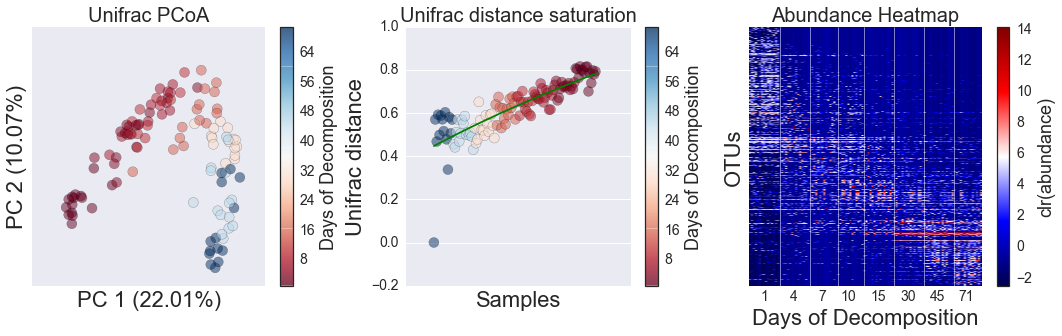

In [10]:
fig = plt.figure(figsize=(20, 5))

gs = GridSpec(100, 100, bottom=0.18,left=0.18,right=0.88)

ax1 = fig.add_subplot(gs[:, :29])
ax2 = fig.add_subplot(gs[:, 37:65])
ax3 = fig.add_subplot(gs[:, 71:])
sns.set_style('white')

## Plot 1
perc_explained = pc.eigvals / pc.eigvals.sum()
samples, mapping = match(pc.samples, mapping)
im = ax1.scatter(samples.PC1, samples.PC2, c=mapping.harvest_time_days, cmap=plt.cm.RdBu, alpha=0.5, s=100)
ax1.set_xlabel('PC 1 ({:.2%})'.format(perc_explained[0]), fontsize=22)
ax1.set_ylabel('PC 2 ({:.2%})'.format(perc_explained[1]), fontsize=22)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Unifrac PCoA', fontsize=20)
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label('Days of Decomposition', fontsize=18)
cbar.ax.tick_params(labelsize=14)

## Plot 2
mapping = mapping.sort_values('harvest_time_days')
samples = pc.samples.reindex(mapping.index)
im = ax2.scatter(np.arange(len(samples.index)), distances[::-1],
                 c=mapping.harvest_time_days[::-1], cmap=plt.cm.RdBu, alpha=0.5, s=100)
ax2.plot(x, np.log(predict), '-g')
ax2.set_title('Unifrac distance saturation', fontsize=20) 
ax2.set_xlabel('Samples', fontsize=22)
ax2.set_ylabel('Unifrac distance', fontsize=22)
ax2.set_xticks([])
#ax2.set_yticks(fontsize=20)
cbar = fig.colorbar(im, ax=ax2)
cbar.set_label('Days of Decomposition', fontsize=18)
cbar.ax.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)


## Plot 3
im = ax3.imshow(clr(multiplicative_replacement(otu_table)).T, 
                cmap=plt.cm.seismic, aspect='auto')
ticks = mapping.harvest_time_days.value_counts().sort_index().cumsum()
ax3.set_xticks(ticks.values, minor=False)
ax3.set_xticks(ticks.values-8, minor=True)
ax3.set_yticks([])
ax3.set_xticklabels(ticks.index.astype(int), fontsize=14, minor=True)
ax3.set_xticklabels([], fontsize=14, minor=False)
ax3.set_xlabel('Days of Decomposition', fontsize=22)
ax3.set_ylabel('OTUs', fontsize=22)
ax3.set_title('Abundance Heatmap', fontsize=20)
ax3.grid(which='major', color='w', linestyle='-', linewidth=0.5)

cbar = fig.colorbar(im, ax=ax3) 
cbar.set_label('clr(abundance)', fontsize=18)
cbar.ax.tick_params(labelsize=14) 
fig.savefig('../results/post_mortem.pdf')

In [11]:
pc.write('../results/mice_unifrac_ord.txt')

'../results/mice_unifrac_ord.txt'

In [12]:
clr_table = pd.DataFrame(clr(multiplicative_replacement(otu_table)),
                         index=otu_table.index, columns=otu_table.columns)

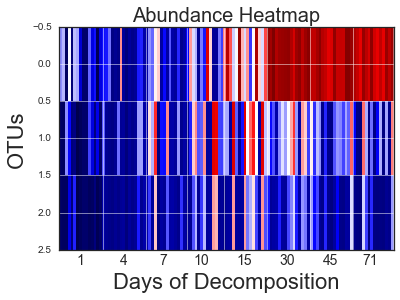

In [13]:
fig, ax3 = plt.subplots()
im = ax3.imshow(clr_table[['4301099', '46026', '4482362']].T, 
                cmap=plt.cm.seismic, aspect='auto', interpolation='nearest')
ticks = mapping.harvest_time_days.value_counts().sort_index().cumsum()
ax3.set_xticks(ticks.values, minor=False)
ax3.set_xticks(ticks.values-8, minor=True)

yticks = mapping.harvest_time_days.value_counts().sort_index().cumsum()

#ax3.set_yticks([])
ax3.set_xticklabels(ticks.index.astype(int), fontsize=14, minor=True)
ax3.set_xticklabels([], fontsize=14, minor=False)
ax3.set_yticklabels(['4301099', '46026', '4482362'],  fontsize=14, minor=True)
ax3.set_xlabel('Days of Decomposition', fontsize=22)
ax3.set_ylabel('OTUs', fontsize=22)
ax3.set_title('Abundance Heatmap', fontsize=20)
ax3.grid(which='major', color='w', linestyle='-', linewidth=0.5)

In [14]:
data = pd.merge(clr_table[['4301099', '46026', '4482362']], mapping, left_index=True, right_index=True)
data = pd.melt(data, id_vars='harvest_time_days', value_vars=['4301099', '46026', '4482362'],
              var_name=['OTU'], value_name='clr(abundance)')

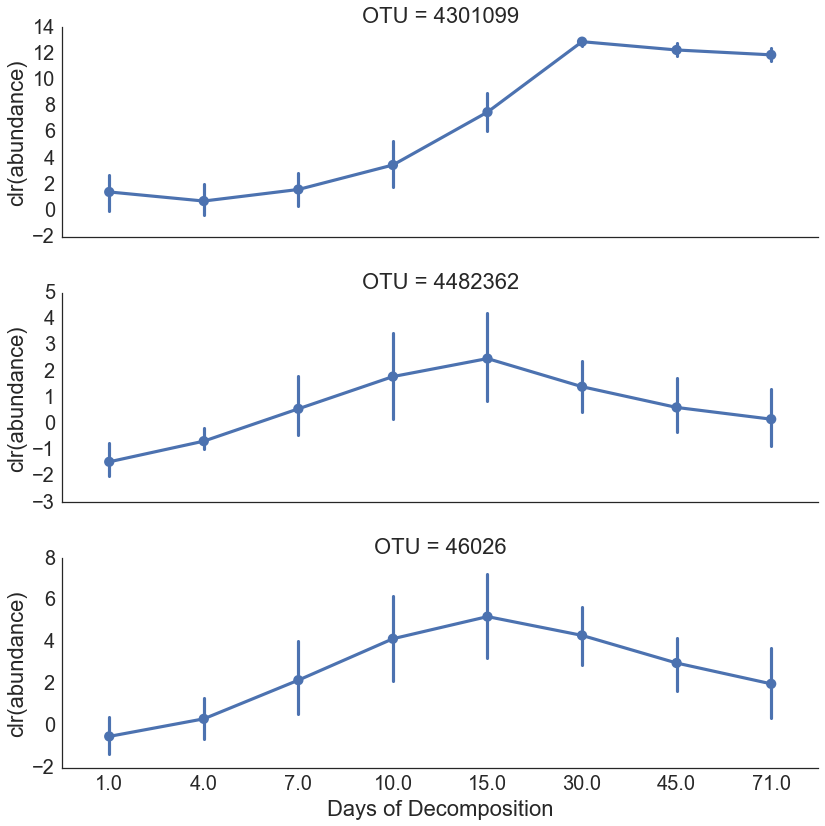

In [15]:
sns.set(font_scale=2) 
sns.set_style('white')
a2 = sns.factorplot(y='clr(abundance)', x='harvest_time_days', row='OTU', 
                    data=data, size=4, aspect=3, sharey=False) 
a2.axes[2][0].set_xlabel('Days of Decomposition')
a2.savefig('../results/clr_abundance.png')

In [16]:
submapping = mapping.loc[np.logical_or(mapping.harvest_time_days == 1, mapping.harvest_time_days == 71)]
dm_df = pd.DataFrame(dm.data, index=dm.ids, columns=dm.ids)
dm_df = dm_df.loc[submapping.index, submapping.index]
subdm = DistanceMatrix(dm_df.values, ids=dm_df.index)

In [17]:
permanova(subdm , submapping.harvest_time_days, permutations=9999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      29
number of groups                  2
test statistic              25.5584
p-value                      0.0001
number of permutations         9999
Name: PERMANOVA results, dtype: object

In [ ]:
embad_dm = embad(otu_table)
pc = pcoa(embad_dm)
pc.write('../results/dead_bodies_embad_pcoa.txt')